# Compare BART versions

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc_bart as pmb
from numba import njit

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
# Load R results
# results with the two most important variables
data_2v = np.stack(
    [
        np.loadtxt(
            f"boston_R-BART_{i:02d}.csv",
            skiprows=1,
            usecols=range(1, 508),
            delimiter=",",
        )
        for i in range(1, 5)
    ]
)
# results with all variables
data = np.stack(
    [
        np.loadtxt(
            f"boston_R-BART_{i:02d}_full.csv",
            skiprows=1,
            usecols=range(1, 508),
            delimiter=",",
        )
        for i in range(1, 5)
    ]
)

In [4]:
data_2v.shape, data.shape

((4, 1000, 507), (4, 1000, 507))

In [5]:
# load original dataset
boston = pd.read_csv("Boston.csv")

### Calculate log_likelihoods for R results

In [6]:
@njit
def gaussian_log_pdf(y, mean, sigma):
    return -np.log(sigma) - 0.5 * np.log(2 * np.pi) - 0.5 * ((y - mean) / sigma) ** 2

In [7]:
# log_likelihood for results with 2 variables
log_llh_2v = np.zeros_like(data_2v[:, :, 1:])
# The R-BART results have a sigma and 506 y_hat in each sample
for chain in range(data_2v.shape[0]):
    for idx_d, draw in enumerate(data_2v[chain]):
        sigma = draw[0]
        for idx_y, (y, y_hat) in enumerate(zip(boston["medv"], draw[1:])):
            log_llh_2v[chain, idx_d, idx_y] = gaussian_log_pdf(y, y_hat, sigma)

In [8]:
log_llh_2v.shape

(4, 1000, 506)

In [9]:
idata_R_2v = az.from_dict({"sigma": data_2v[:, :, 0], "y_hat": data_2v[:, :, 1:]})
idata_R_2v.add_groups(log_likelihood={"y": log_llh_2v})

In [10]:
# log_likelihood for results with all variables
log_llh = np.zeros_like(data[:, :, 1:])
# The R-BART results have a sigma and 506 y_hat in each sample
for chain in range(data.shape[0]):
    for idx_d, draw in enumerate(data[chain]):
        sigma = draw[0]
        for idx_y, (y, y_hat) in enumerate(zip(boston["medv"], draw[1:])):
            log_llh[chain, idx_d, idx_y] = gaussian_log_pdf(y, y_hat, sigma)

In [11]:
idata_R = az.from_dict({"sigma": data[:, :, 0], "y_hat": data[:, :, 1:]})
idata_R.add_groups(log_likelihood={"y": log_llh})

## `pymc-bart` Gamma and Gaussian distributions  

In [12]:
# load inference data from pymc-bart
idata_pmb_GM_2v = az.from_netcdf(
    "./boston_id_2v_GM.nc"
)  # pmb Gamma distribution, 2 variables
idata_pmb_GM_full = az.from_netcdf(
    "./boston_id_full_GM.nc"
)  # pmb Gamma distribution, all variables
idata_pmb_GAUSS_2v = az.from_netcdf(
    "./boston_id_2v_GAUSS.nc"
)  # pmb Gaussian distribution, 2 variables
idata_pmb_GAUSS_full = az.from_netcdf(
    "./boston_id_full_GAUSS.nc"
)  # pmb Gaussian distribution, all variables

In [13]:
names = ["R-2V", "pmb-2V-GM", "pmb-2V-G", "R-all", "pmb-all-GM", "pmb-all-G"]
idatas = [
    idata_R_2v,
    idata_pmb_GM_2v,
    idata_pmb_GAUSS_2v,
    idata_R,
    idata_pmb_GM_full,
    idata_pmb_GAUSS_full,
]

### Using the two most important variables  

#### Convergence plots

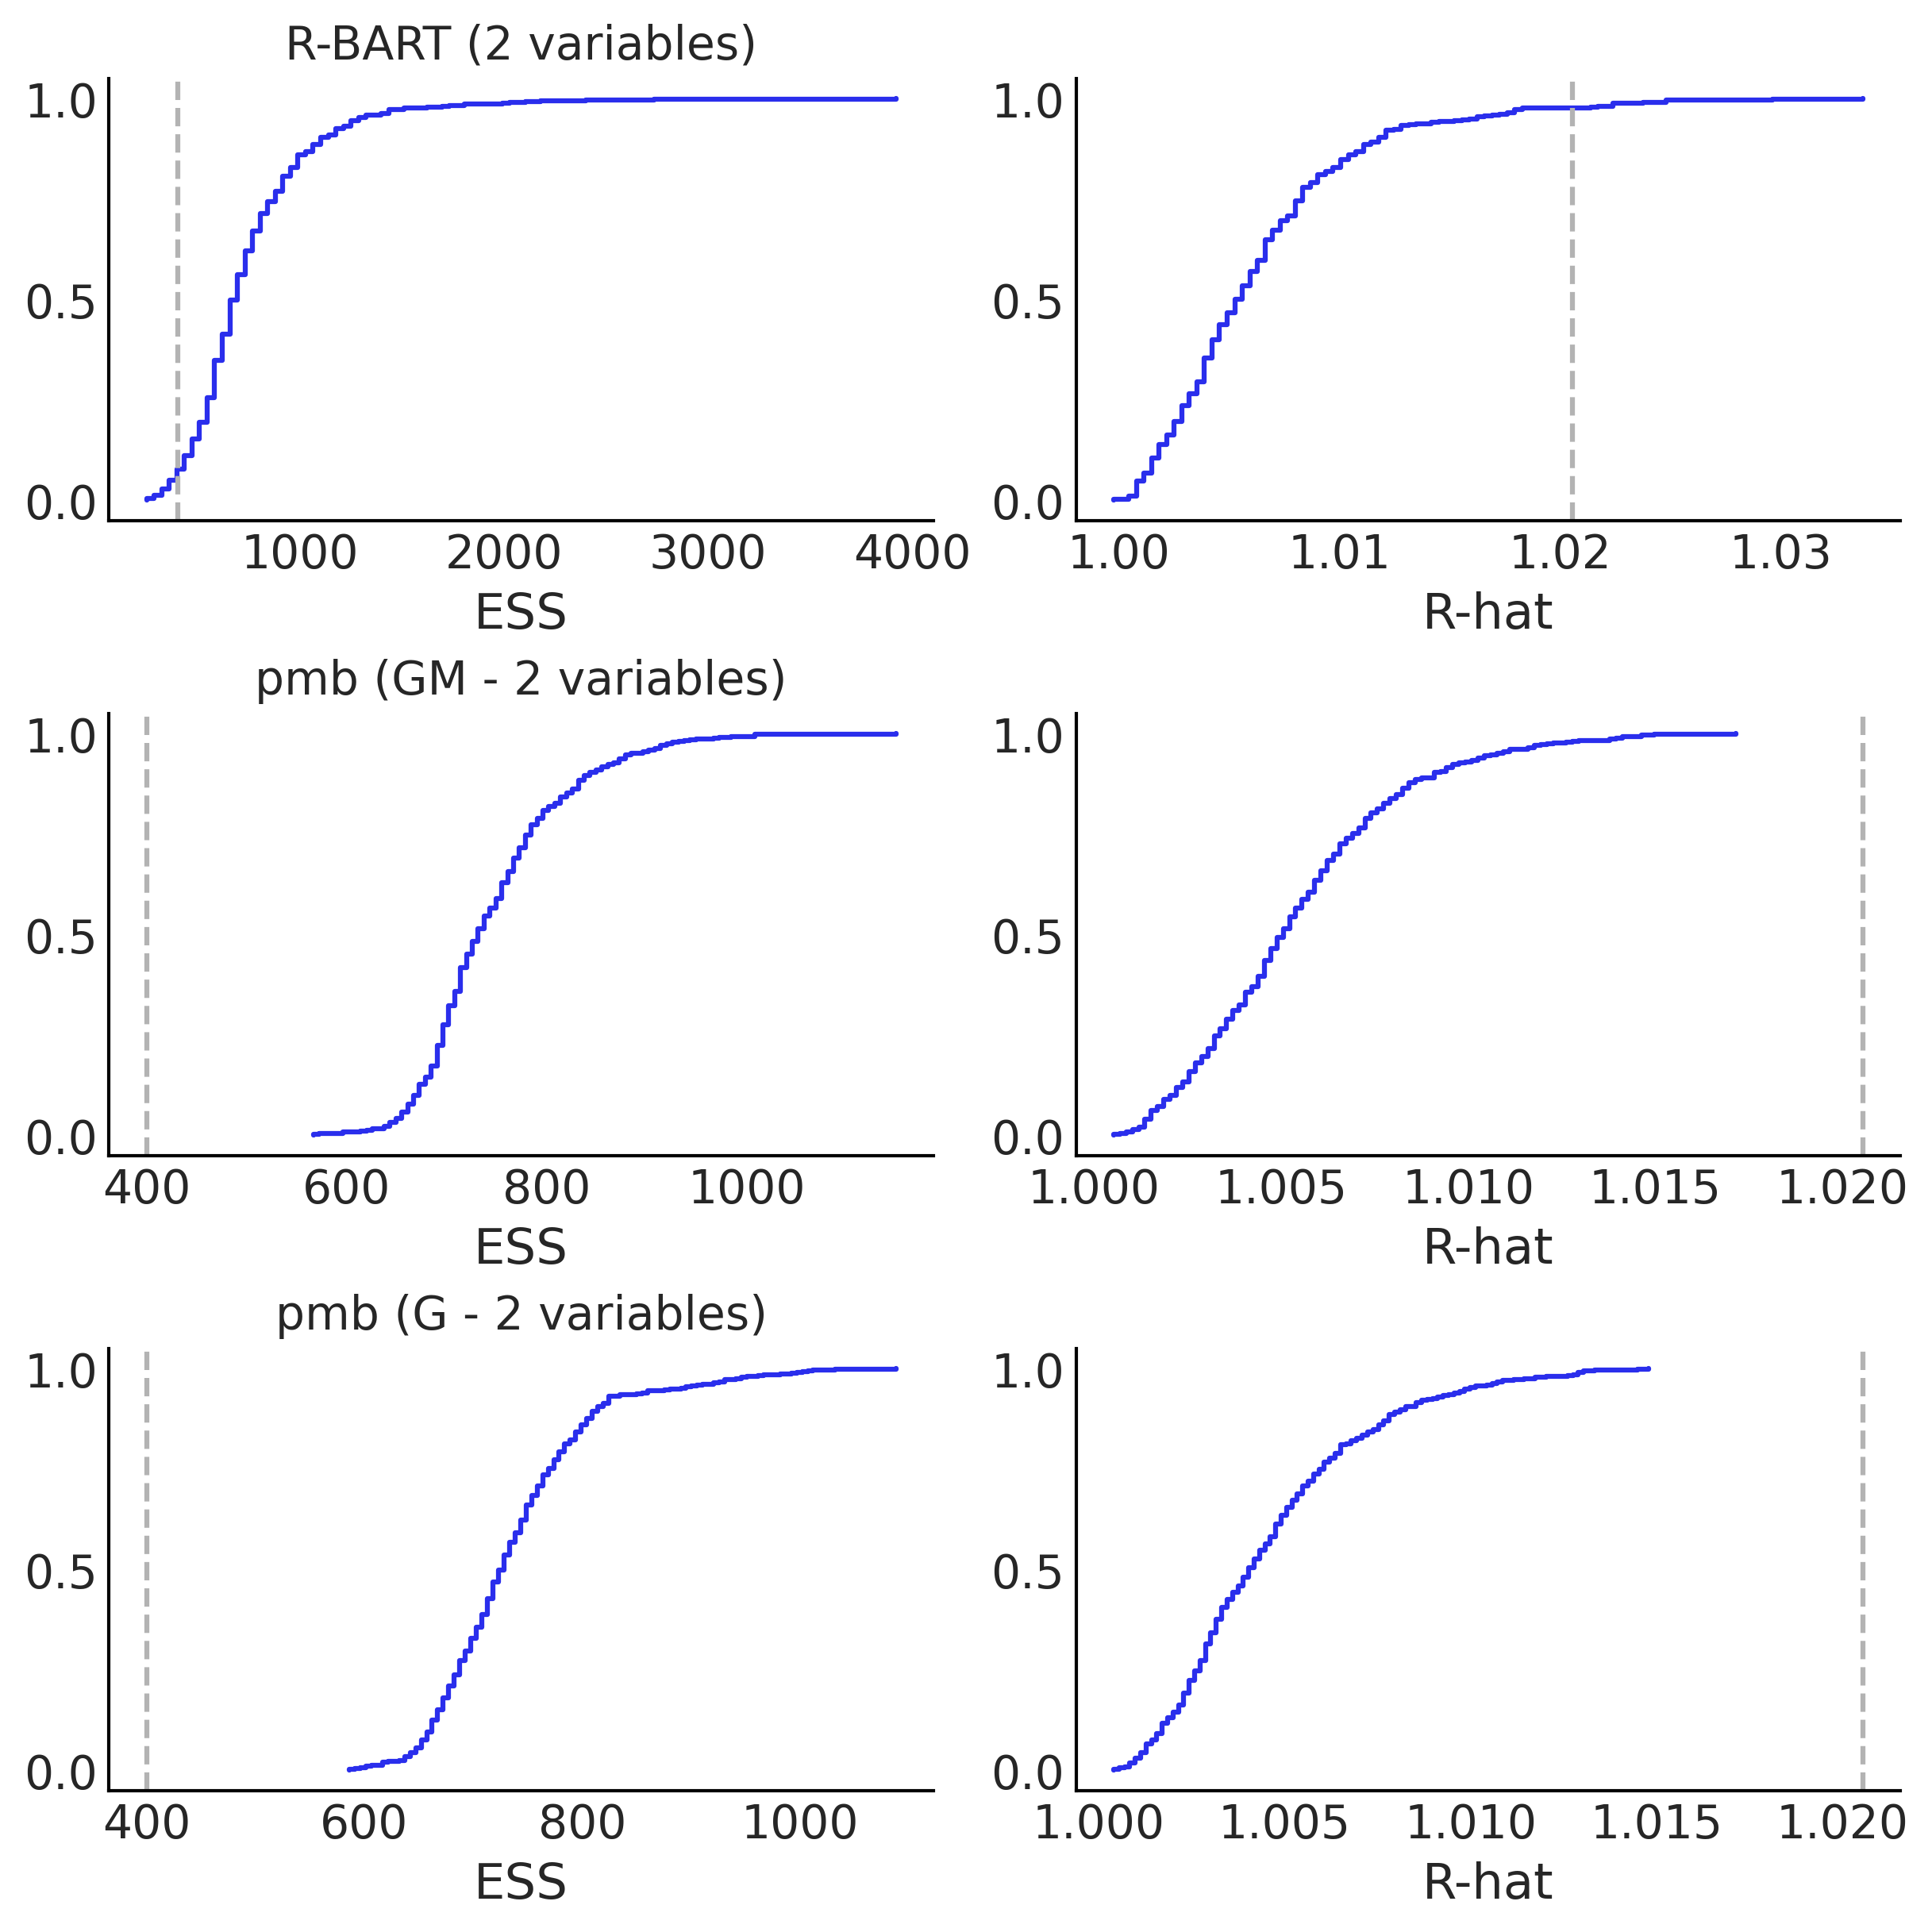

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

axs = axes.ravel()

pmb.plot_convergence(idata_R_2v, var_name="y_hat", ax=[axs[0], axs[1]])
pmb.plot_convergence(idata_pmb_GM_2v, var_name="μ", ax=[axs[2], axs[3]])
pmb.plot_convergence(idata_pmb_GAUSS_2v, var_name="μ", ax=[axs[4], axs[5]])

axs[0].set_title("R-BART (2 variables)", size=14)
axs[2].set_title("pmb (GM - 2 variables)", size=14)
axs[4].set_title("pmb (G - 2 variables)", size=14);

# fig.subplots_adjust(hspace=0.5);

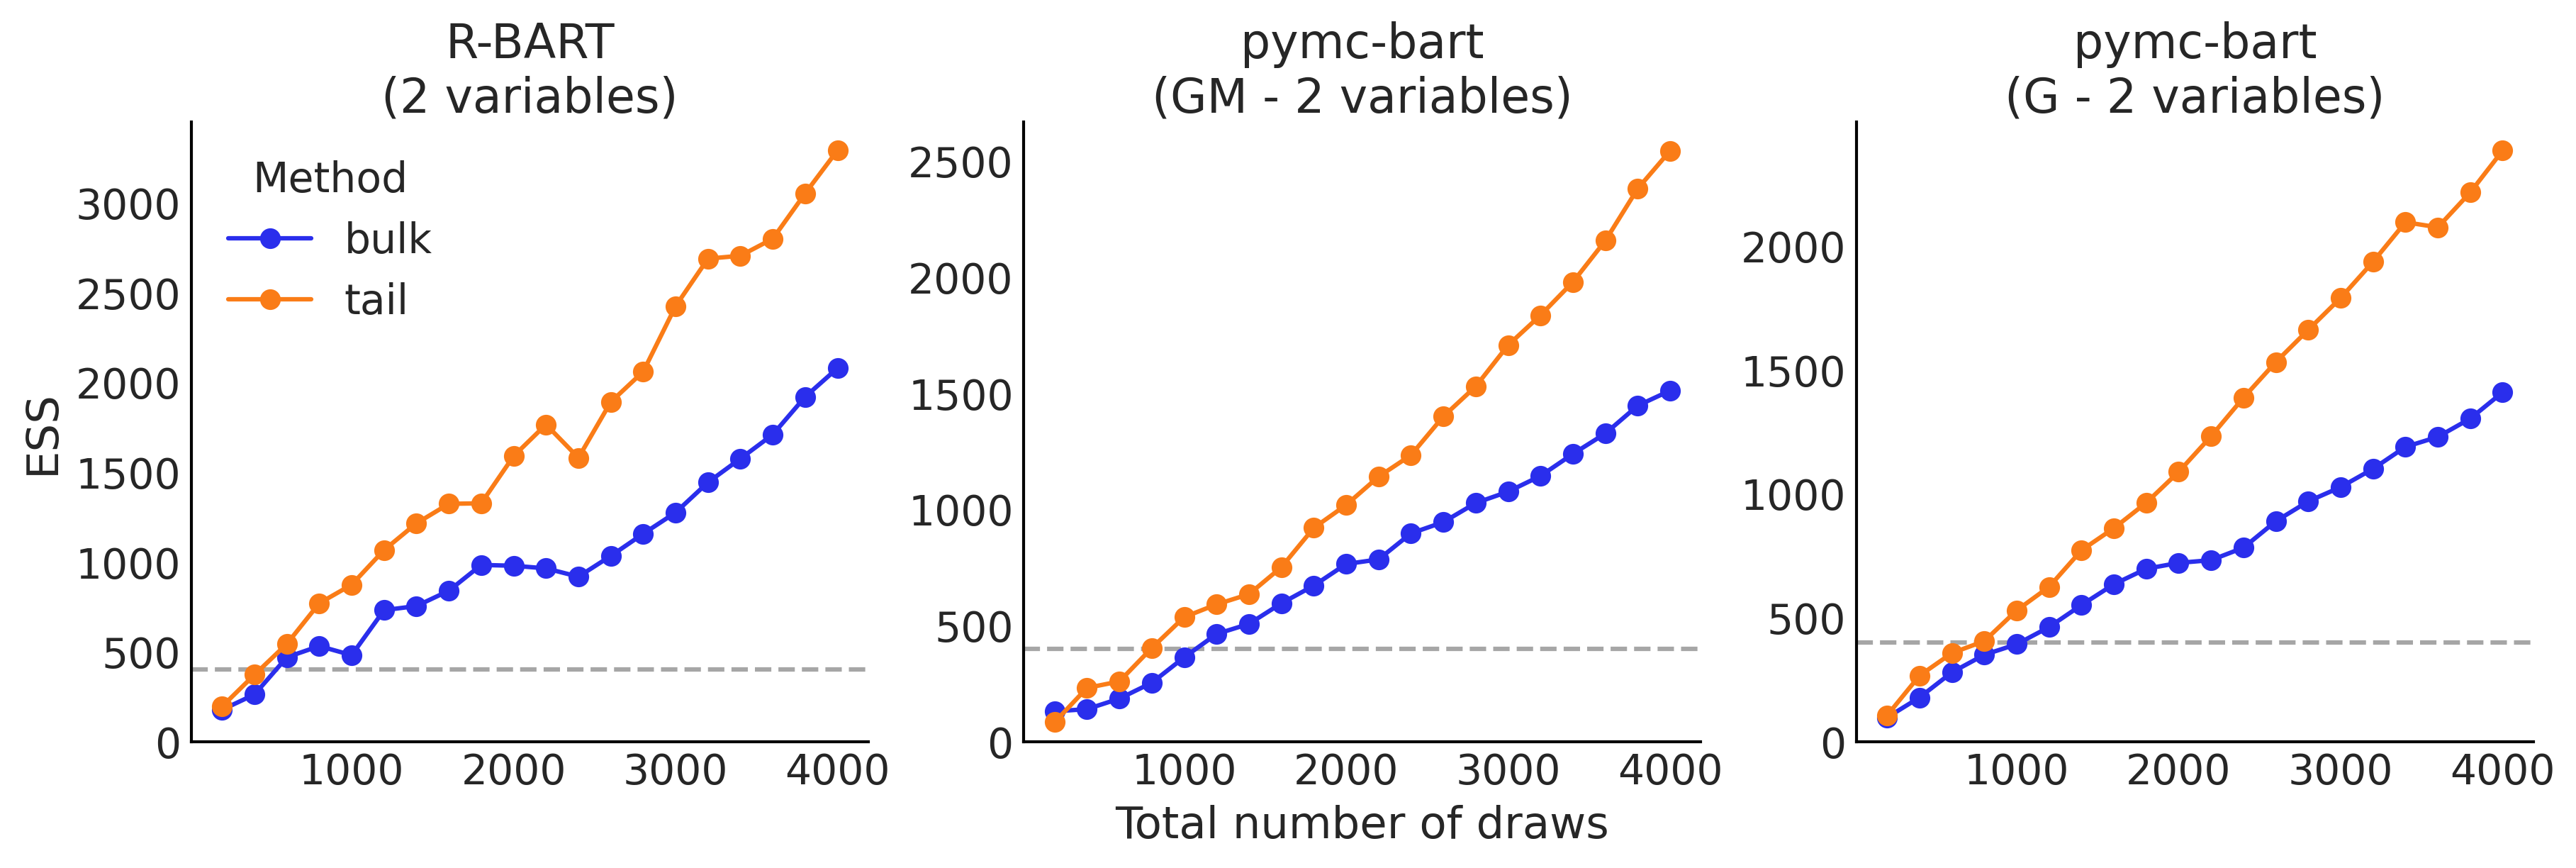

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axs = axes.ravel()

az.plot_ess(idata_R_2v, kind="evolution", var_names=["sigma"], ax=axs[0])
az.plot_ess(idata_pmb_GM_2v, kind="evolution", var_names=["α"], ax=axs[1])
az.plot_ess(idata_pmb_GAUSS_2v, kind="evolution", var_names=["σ"], ax=axs[2])

for ax in axs[1:3]:
    ax.set_ylabel("")
    ax.get_legend().remove()

axs[0].set_title("R-BART\n(2 variables)")
axs[1].set_title("pymc-bart\n(GM - 2 variables)")
axs[2].set_title("pymc-bart\n(G - 2 variables)")

axs[0].set_xlabel("")
axs[2].set_xlabel("");

In [17]:
model_compare = az.compare(
    {
        "pymc-bart_GM": idata_pmb_GM_2v,
        "pymc-bart_G": idata_pmb_GAUSS_2v,
        "r-bart": idata_R_2v,
    }
)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [18]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pymc-bart_GM,0,-1467.723670,23.510325,0.000000,0.284543,24.420574,0.000000,False,log
pymc-bart_G,1,-1469.163192,32.392433,1.439522,0.003873,35.995464,21.820359,True,log
r-bart,2,-1470.861656,63.007619,3.137985,0.711584,39.640061,25.806339,True,log


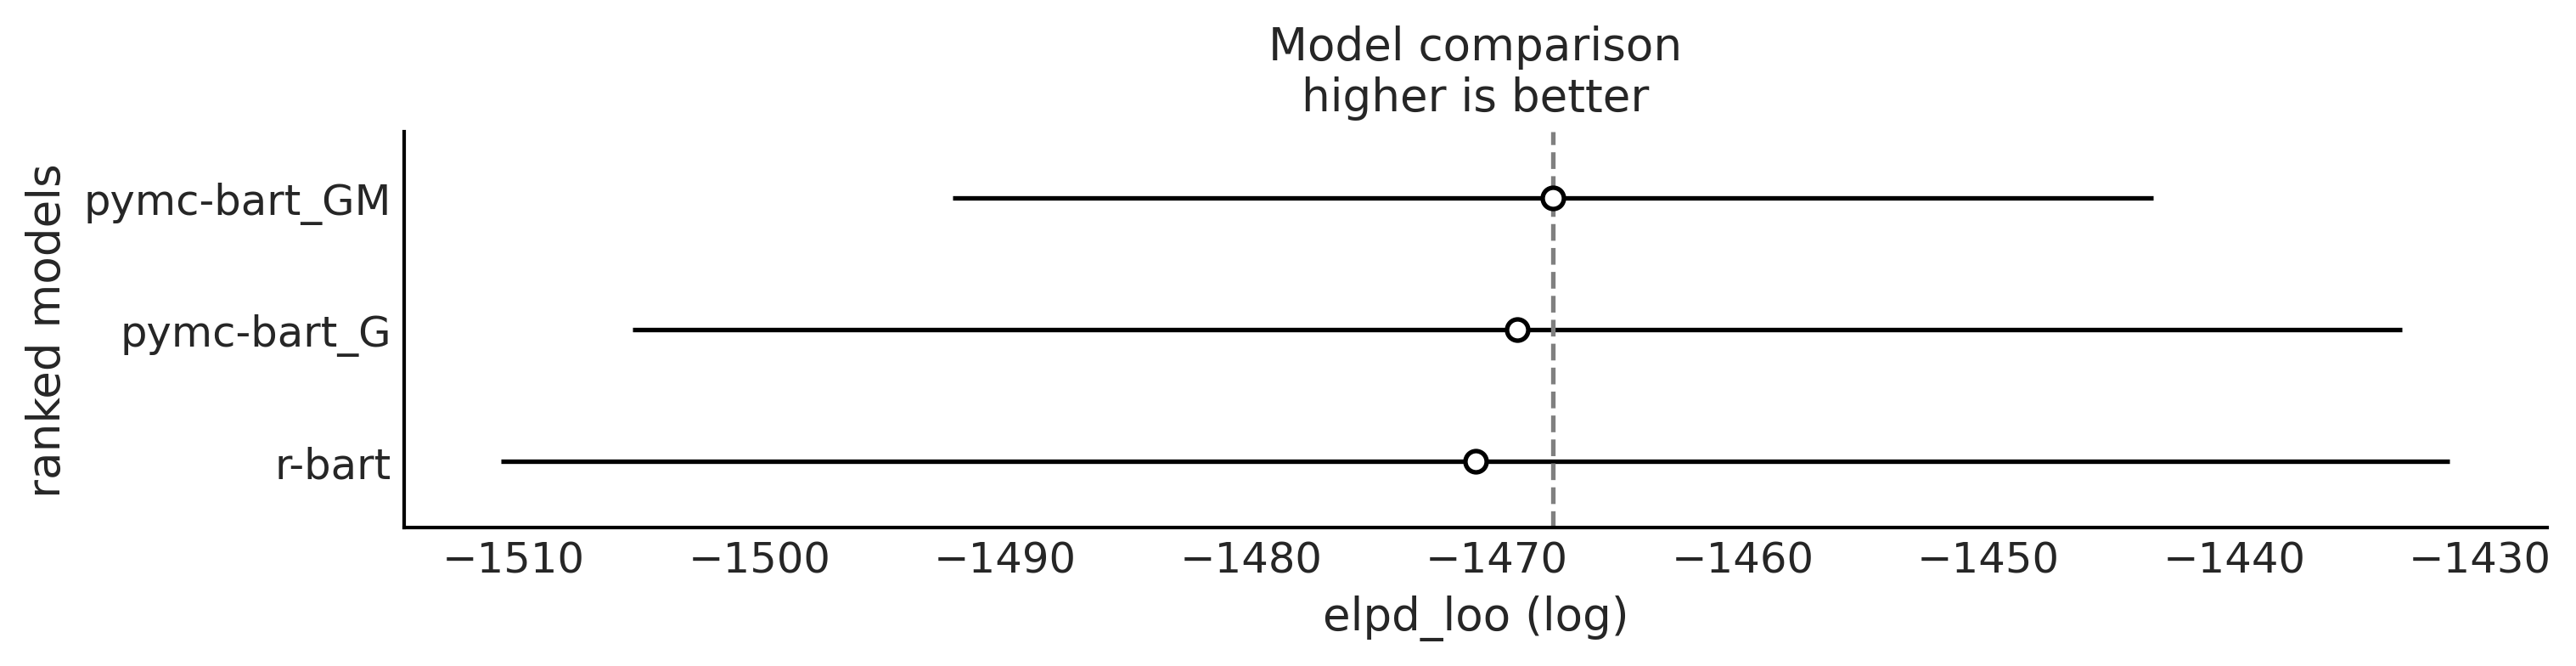

In [19]:
az.plot_compare(
    model_compare,
    plot_ic_diff=False,
    insample_dev=False,
    figsize=(10, 2.5),
    legend=False,
);
# plt.savefig("loo_Rs.png")

#### Predicted vs Observed (2 variables)

In [20]:
Y = boston["medv"]

/tmp/ipykernel_139242/2533984461.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)
/tmp/ipykernel_139242/2533984461.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)


3.9042774055159963
4.162676658833019


/tmp/ipykernel_139242/2533984461.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)


4.152105089960737


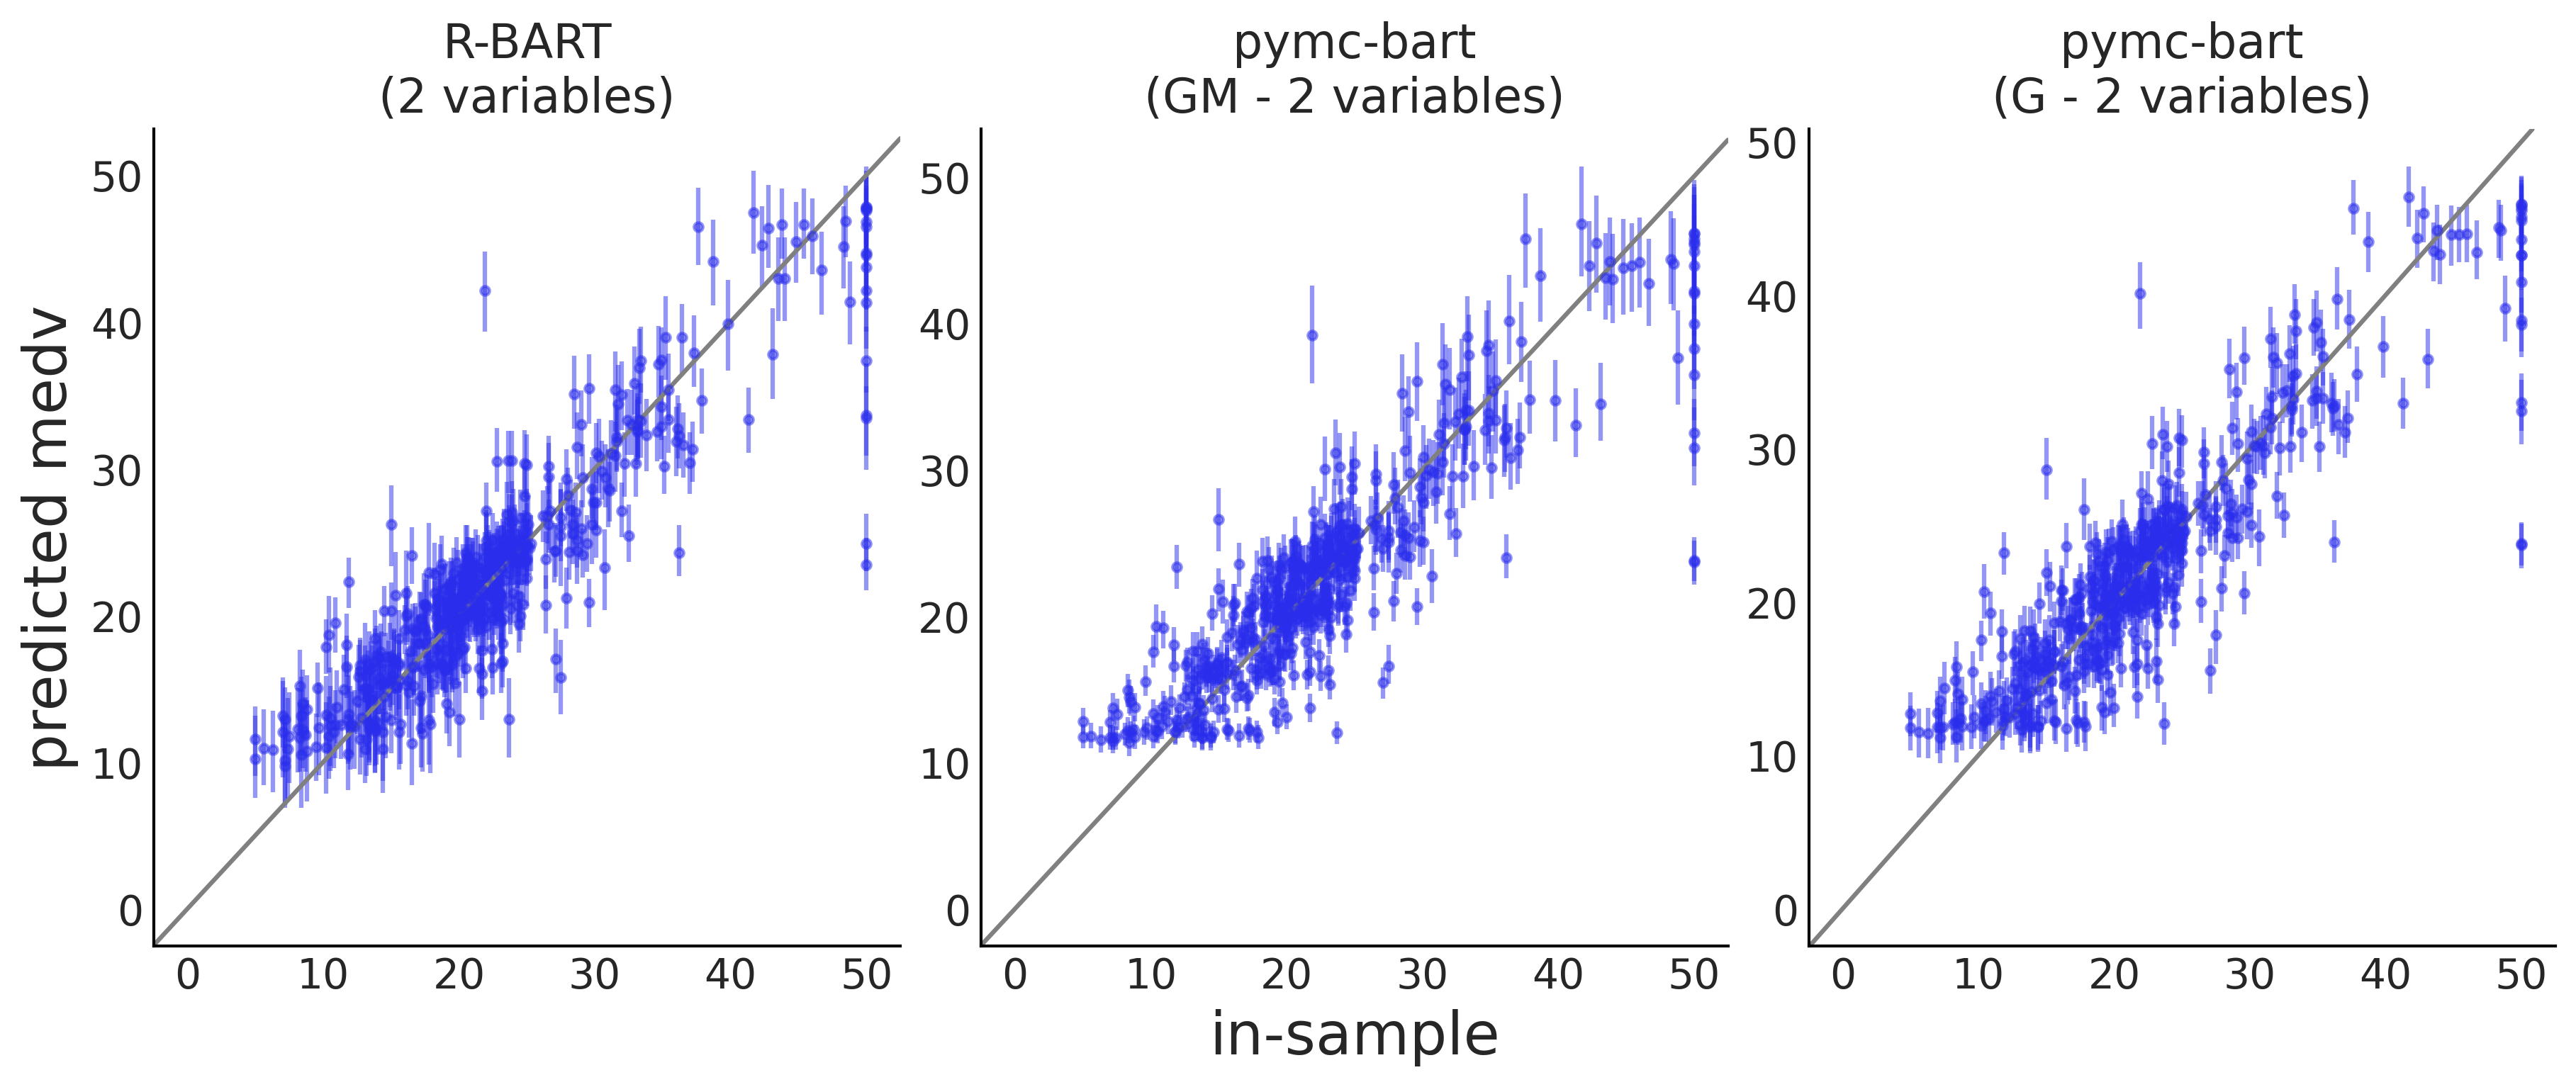

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axs = axes.ravel()

for i in range(len(names[:3])):
    name = names[i]
    idata = idatas[i]
    ax = axs[i]

    if name == "R-2V":
        var = "y_hat"
    else:
        var = "μ"

    y_pred = idata.posterior[f"{var}"].stack(samples=["chain", "draw"])
    mean_y = y_pred.median("samples")
    mean = y_pred.mean("samples")
    hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)
    yerr = np.vstack([mean_y - hdi[:, 0], hdi[:, 1] - mean_y])
    ax.errorbar(Y, mean_y, yerr, linestyle="None", marker=".", alpha=0.5)
    ax.axline([0, 0], [1, 1], color="0.5")
    print(np.mean((Y - mean) ** 2) ** 0.5)

axs[0].set_title("R-BART\n(2 variables)")
axs[1].set_title("pymc-bart\n(GM - 2 variables)")
axs[2].set_title("pymc-bart\n(G - 2 variables)")

axs[0].set_ylabel("predicted medv", size=20)
axs[1].set_xlabel("in-sample", size=20);

<xarray.DataArray ()>
array(11.33871771)
<xarray.DataArray ()>
array(11.37548972)


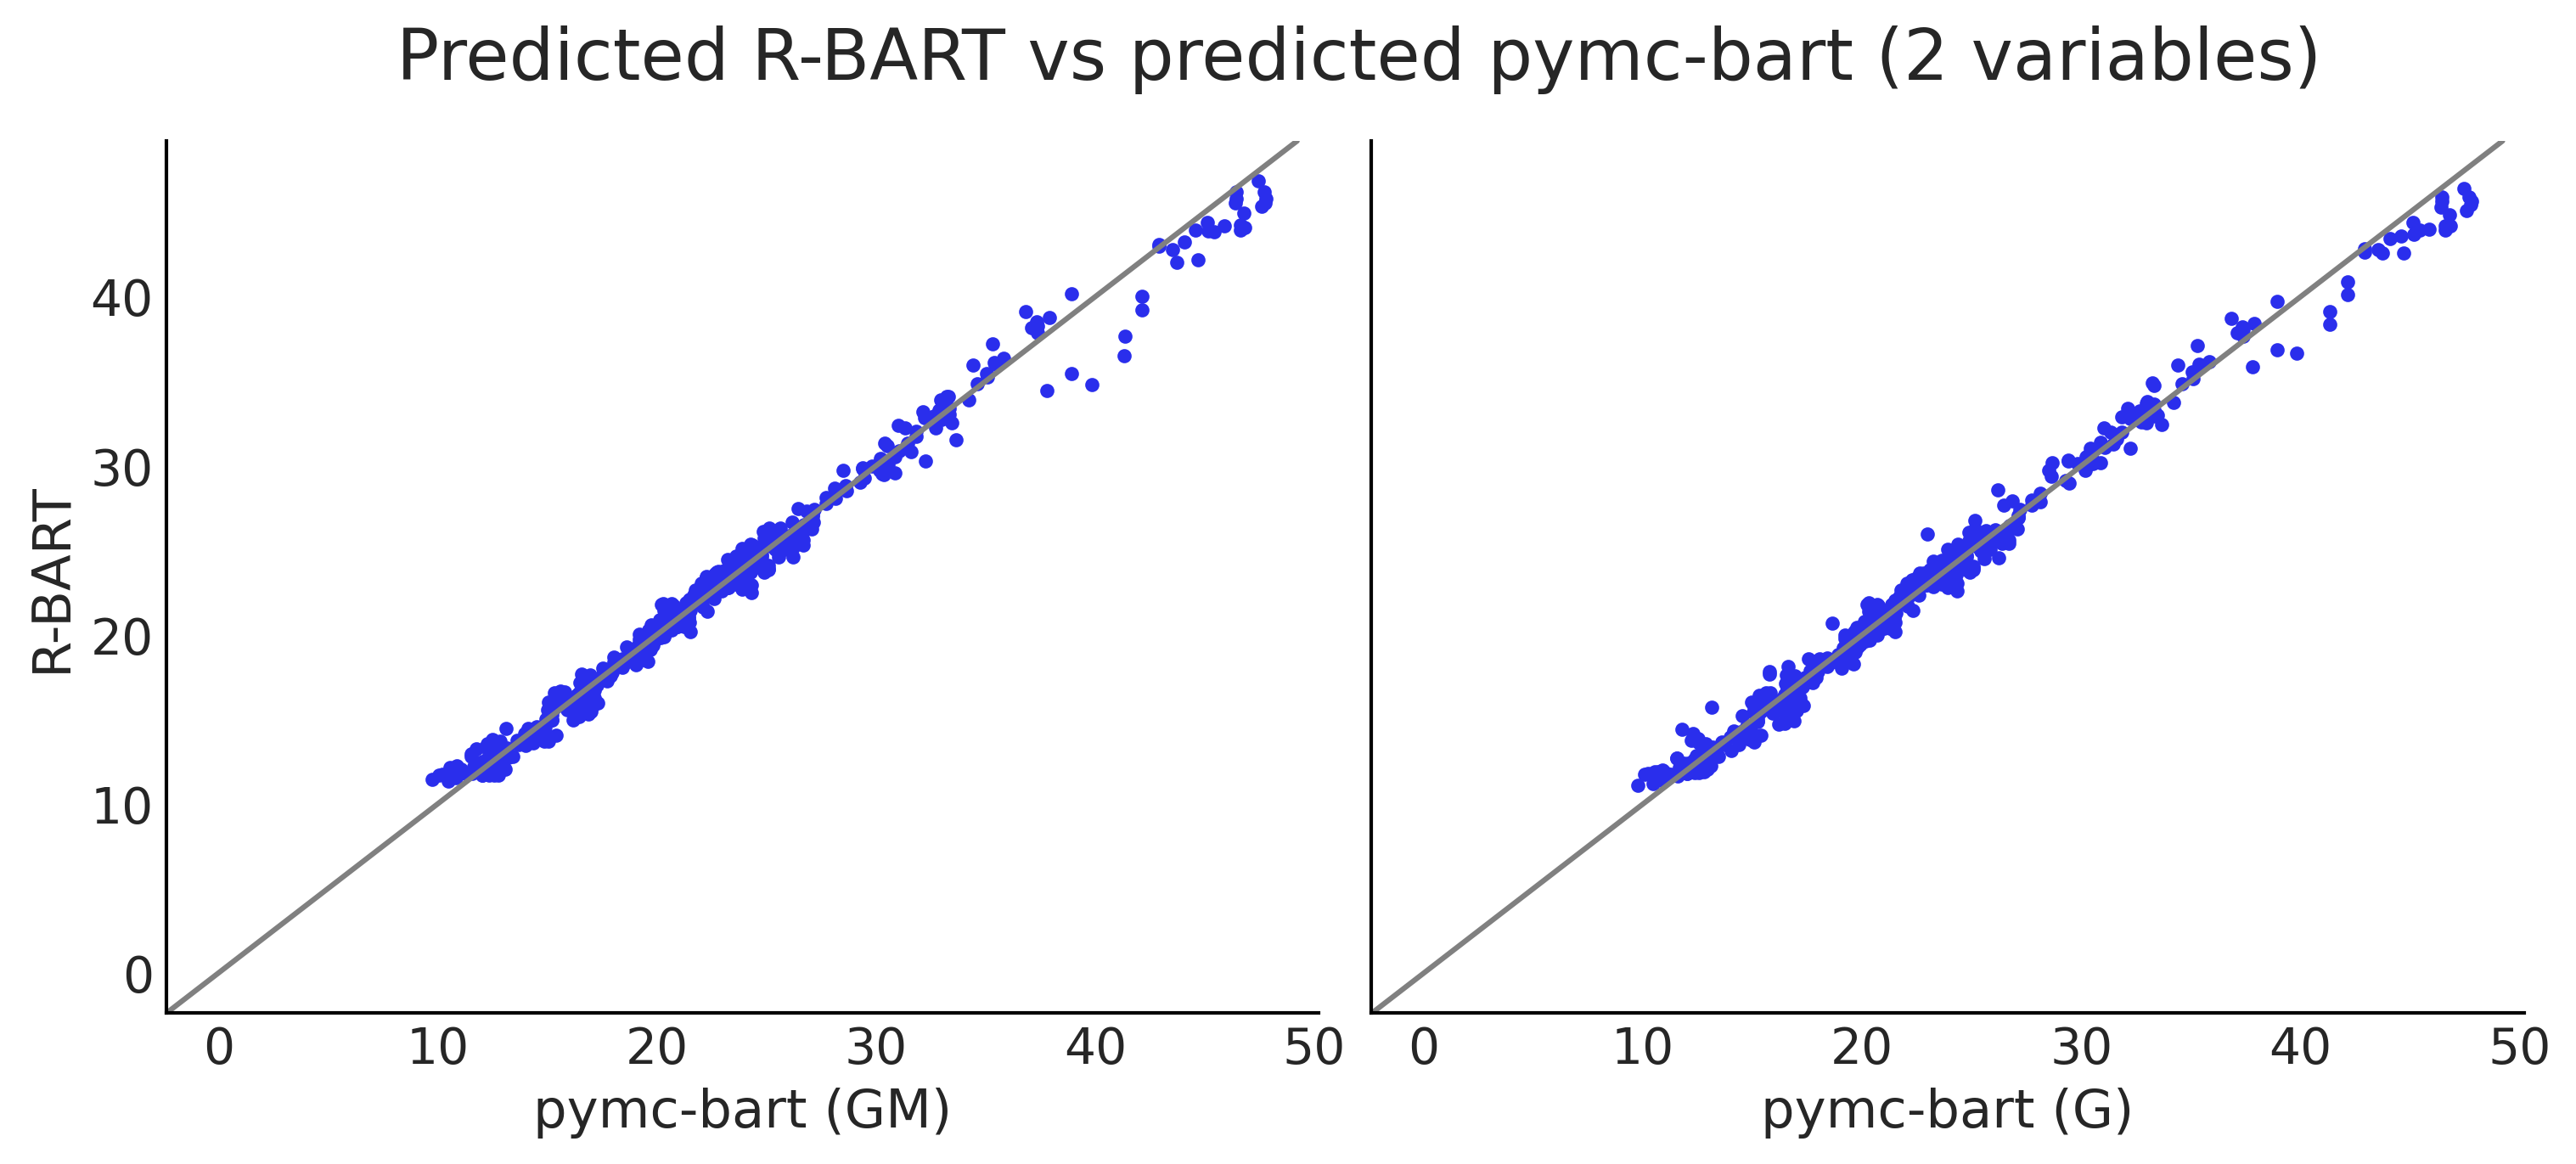

In [22]:
# Predicted pymc-bart vs R-BART
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

axs = axes.ravel()

y_r = idata_R_2v.posterior["y_hat"].stack(samples=["chain", "draw"])
mean_r = y_r.mean("samples")

y_py = idata_pmb_GM_2v.posterior["μ"].stack(samples=["chain", "draw"])
mean_py = y_py.mean("samples")

y_py2 = idata_pmb_GAUSS_2v.posterior["μ"].stack(samples=["chain", "draw"])
mean_py2 = y_py2.mean("samples")

axs[0].plot(mean_r, mean_py, ".")
axs[1].plot(mean_r, mean_py2, ".")

axs[0].axline([0, 0], [1, 1], color="0.5")
axs[1].axline([0, 0], [1, 1], color="0.5")

axs[0].set_ylabel("R-BART")
axs[0].set_xlabel("pymc-bart (GM)")
axs[1].set_xlabel("pymc-bart (G)")

fig.text(
    0.15, 1.05, "Predicted R-BART vs predicted pymc-bart (2 variables)", fontsize=20
)

print(np.mean((mean_r - mean_py) ** 2) ** 0.5)
print(np.mean((mean_r - mean_py2) ** 2) ** 0.5);

## All variables

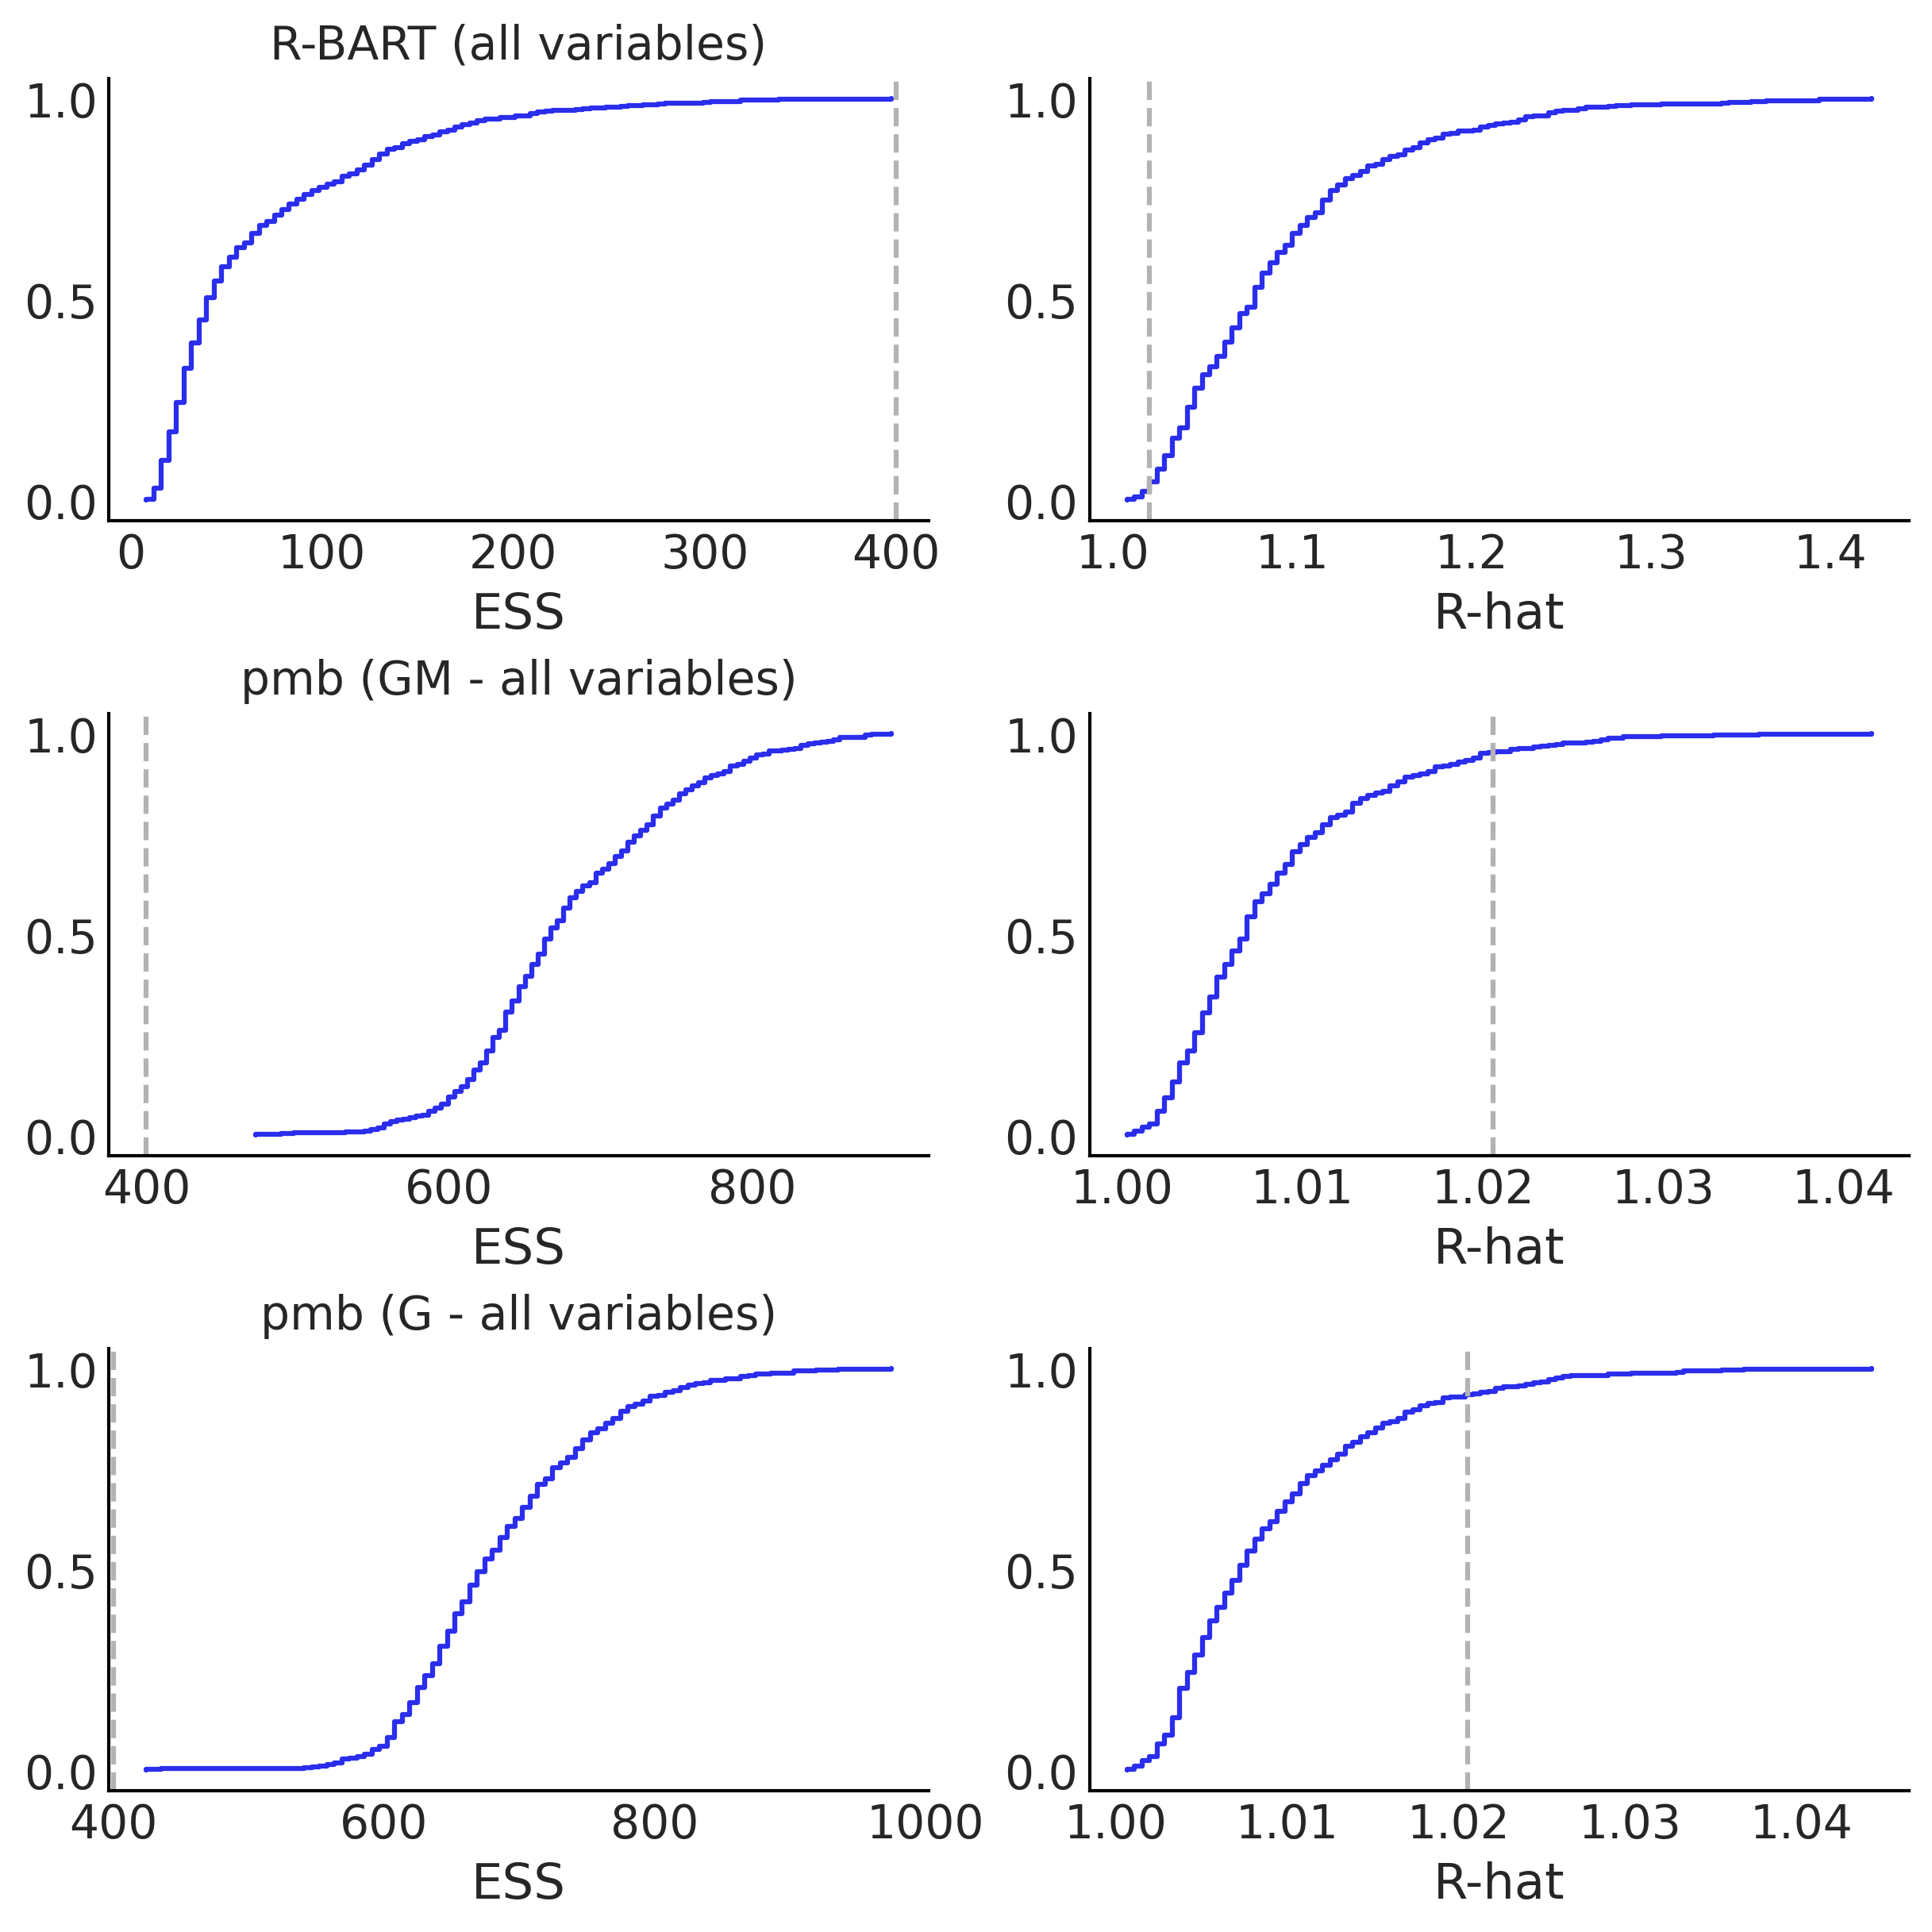

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

axs = axes.ravel()

pmb.plot_convergence(idata_R, var_name="y_hat", ax=[axs[0], axs[1]])
pmb.plot_convergence(idata_pmb_GM_full, var_name="μ", ax=[axs[2], axs[3]])
pmb.plot_convergence(idata_pmb_GAUSS_full, var_name="μ", ax=[axs[4], axs[5]])

axs[0].set_title("R-BART (all variables)", size=14)
axs[2].set_title("pmb (GM - all variables)", size=14)
axs[4].set_title("pmb (G - all variables)", size=14);

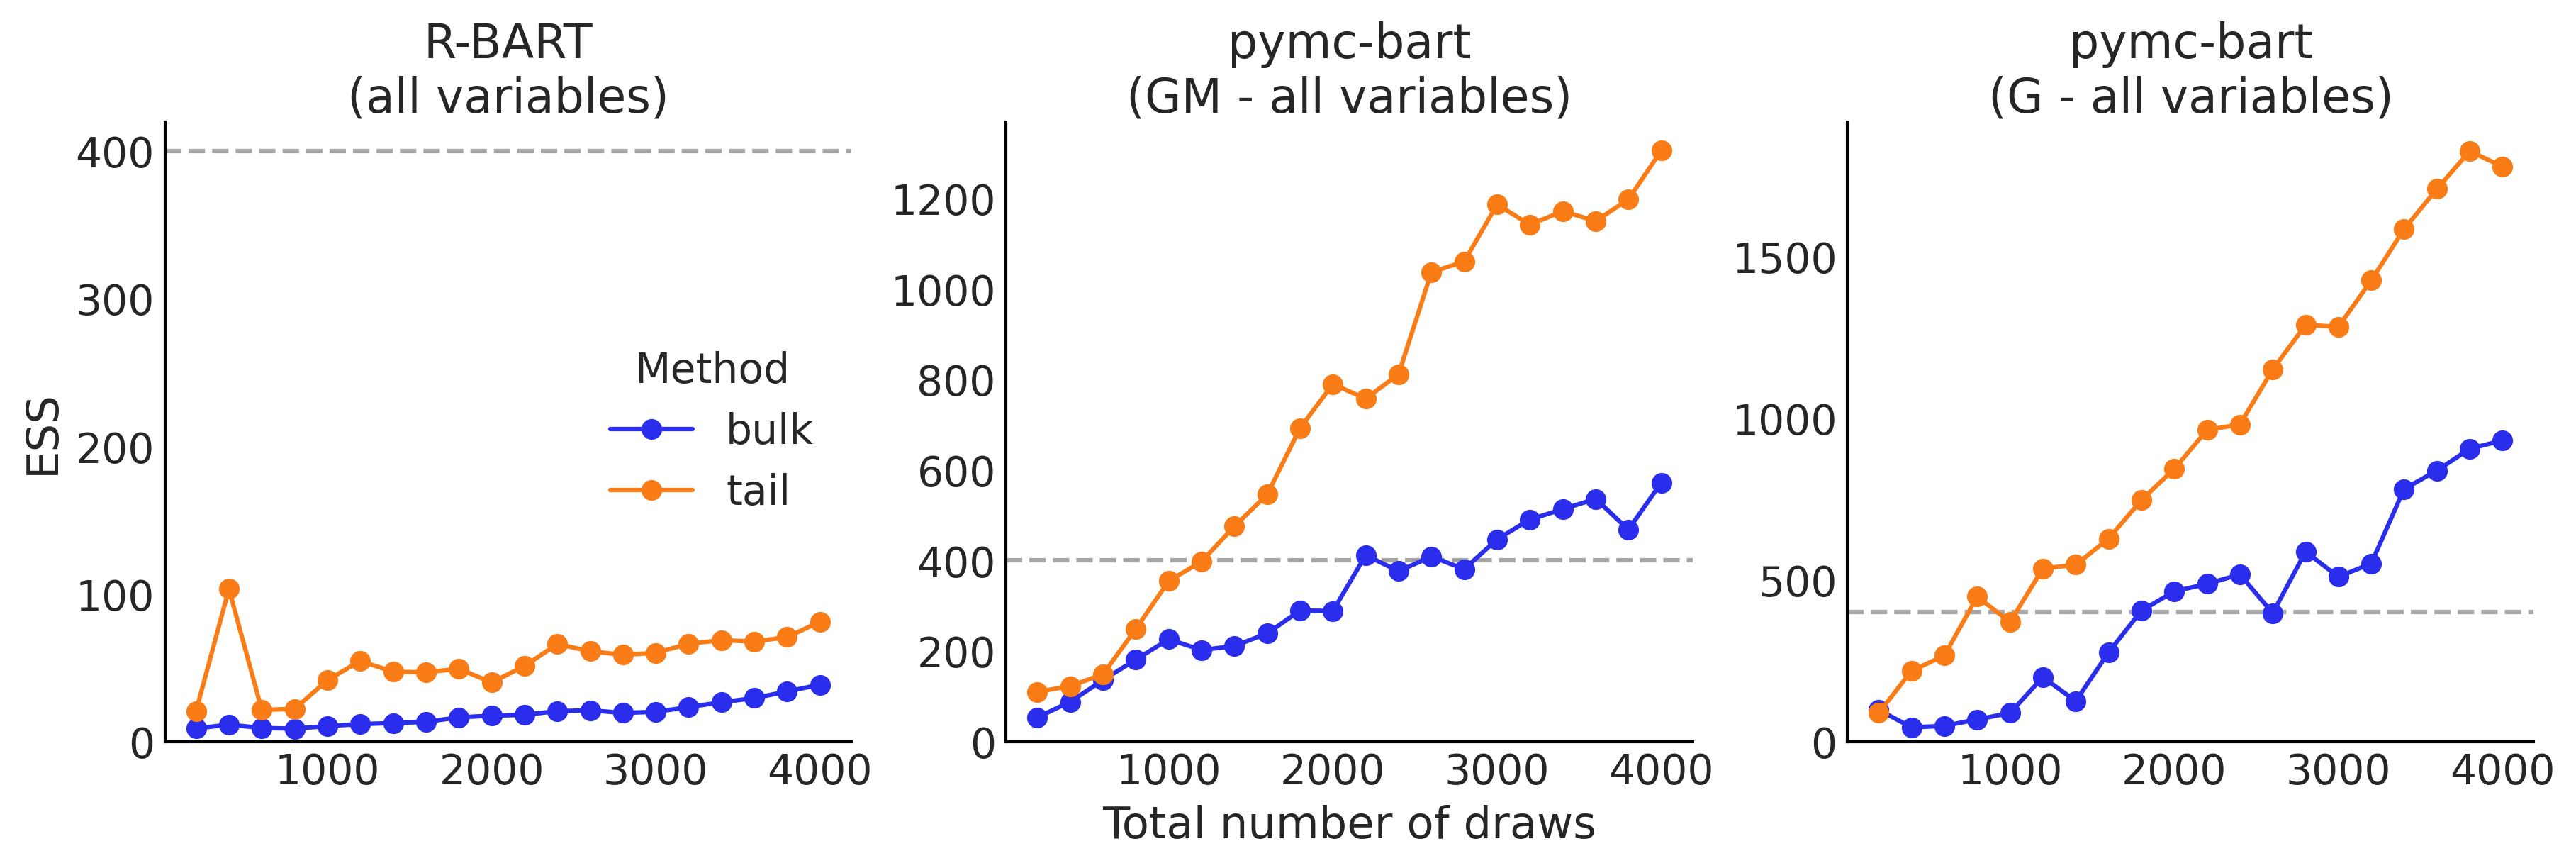

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axs = axes.ravel()

az.plot_ess(idata_R, kind="evolution", var_names=["sigma"], ax=axs[0])
az.plot_ess(idata_pmb_GM_full, kind="evolution", var_names=["α"], ax=axs[1])
az.plot_ess(idata_pmb_GAUSS_full, kind="evolution", var_names=["σ"], ax=axs[2])

for ax in axs[1:3]:
    ax.set_ylabel("")
    ax.get_legend().remove()

axs[0].set_title("R-BART\n(all variables)")
axs[1].set_title("pymc-bart\n(GM - all variables)")
axs[2].set_title("pymc-bart\n(G - all variables)")

axs[0].set_xlabel("")
axs[2].set_xlabel("");

In [25]:
model_compare2 = az.compare(
    {
        "pymc-bart_GM": idata_pmb_GM_full,
        "pymc-bart_G": idata_pmb_GAUSS_full,
        "r-bart": idata_R,
    }
)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/en

In [26]:
model_compare2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
r-bart,0,-1169.320931,200.359350,0.000000,9.701157e-01,27.073269,0.000000,True,log
pymc-bart_GM,1,-1397.736304,63.505040,228.415373,2.988432e-02,32.202772,23.568819,True,log
pymc-bart_G,2,-1426.474965,72.461641,257.154034,5.427894e-10,44.715921,31.365111,True,log


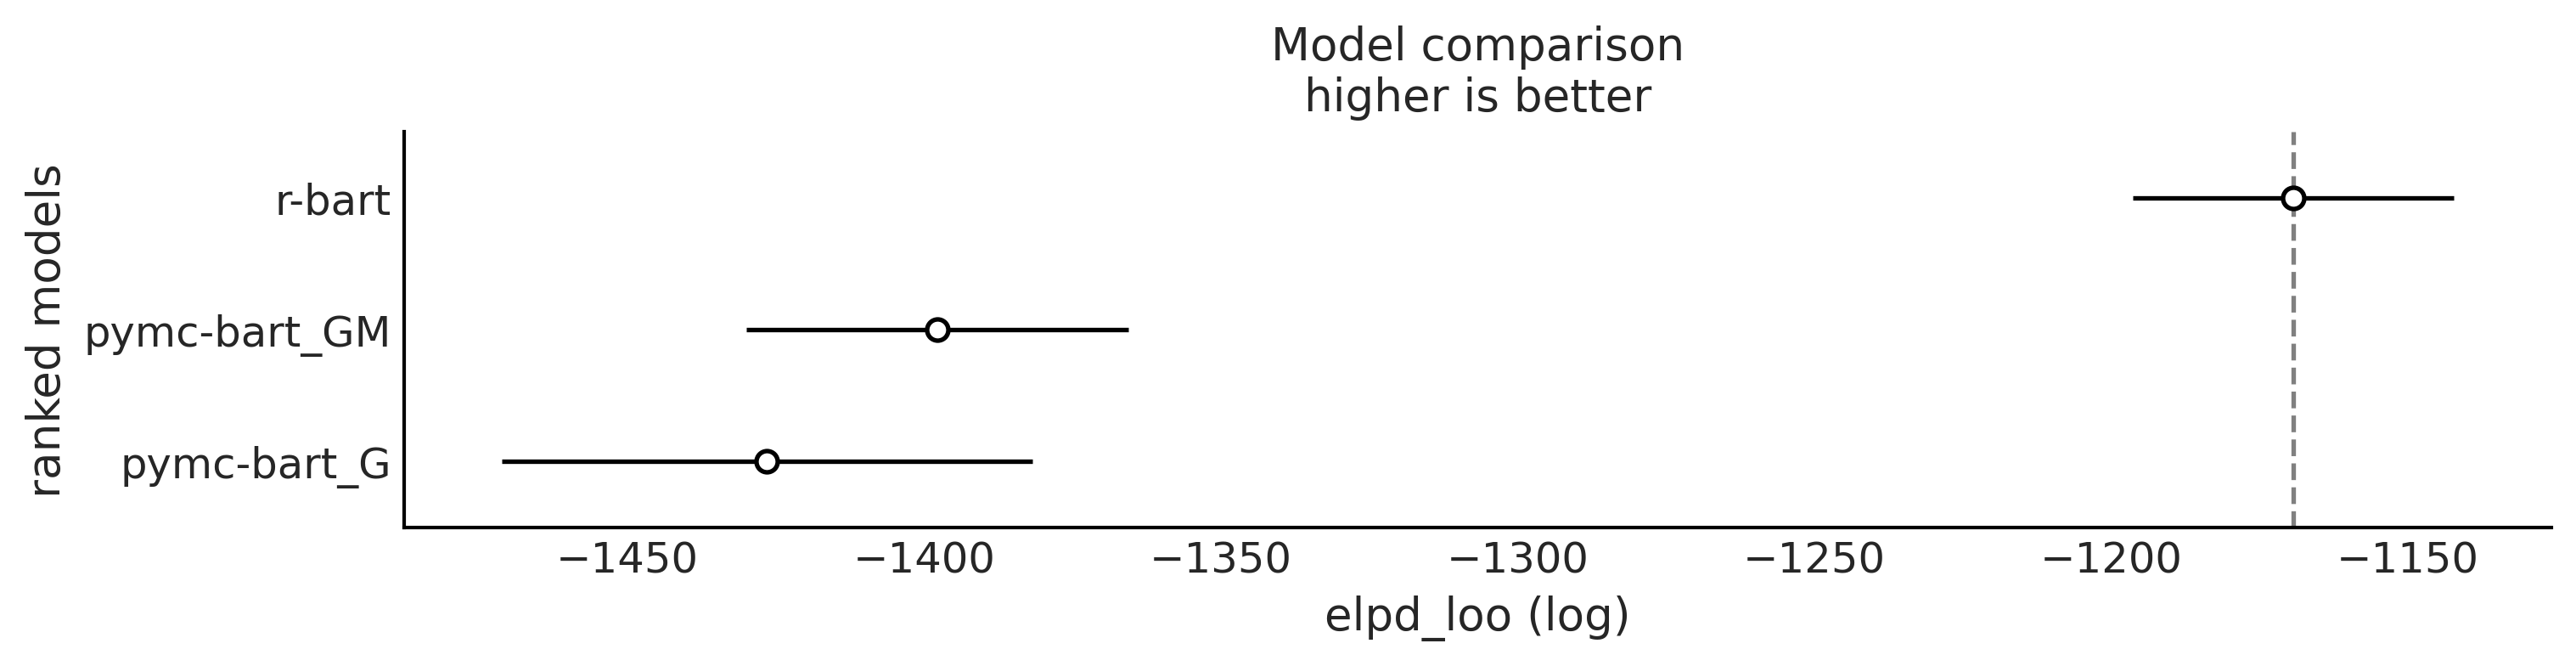

In [27]:
az.plot_compare(
    model_compare2,
    plot_ic_diff=False,
    insample_dev=False,
    figsize=(10, 2.5),
    legend=False,
);
# plt.savefig("loo_full_Rs.png")

### Predicted vs Observed

In [28]:
Y = boston["medv"]

/tmp/ipykernel_139242/1702549615.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)
/tmp/ipykernel_139242/1702549615.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)


1.4543945855655784
3.544415167519829


/tmp/ipykernel_139242/1702549615.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)


3.5201195035135053


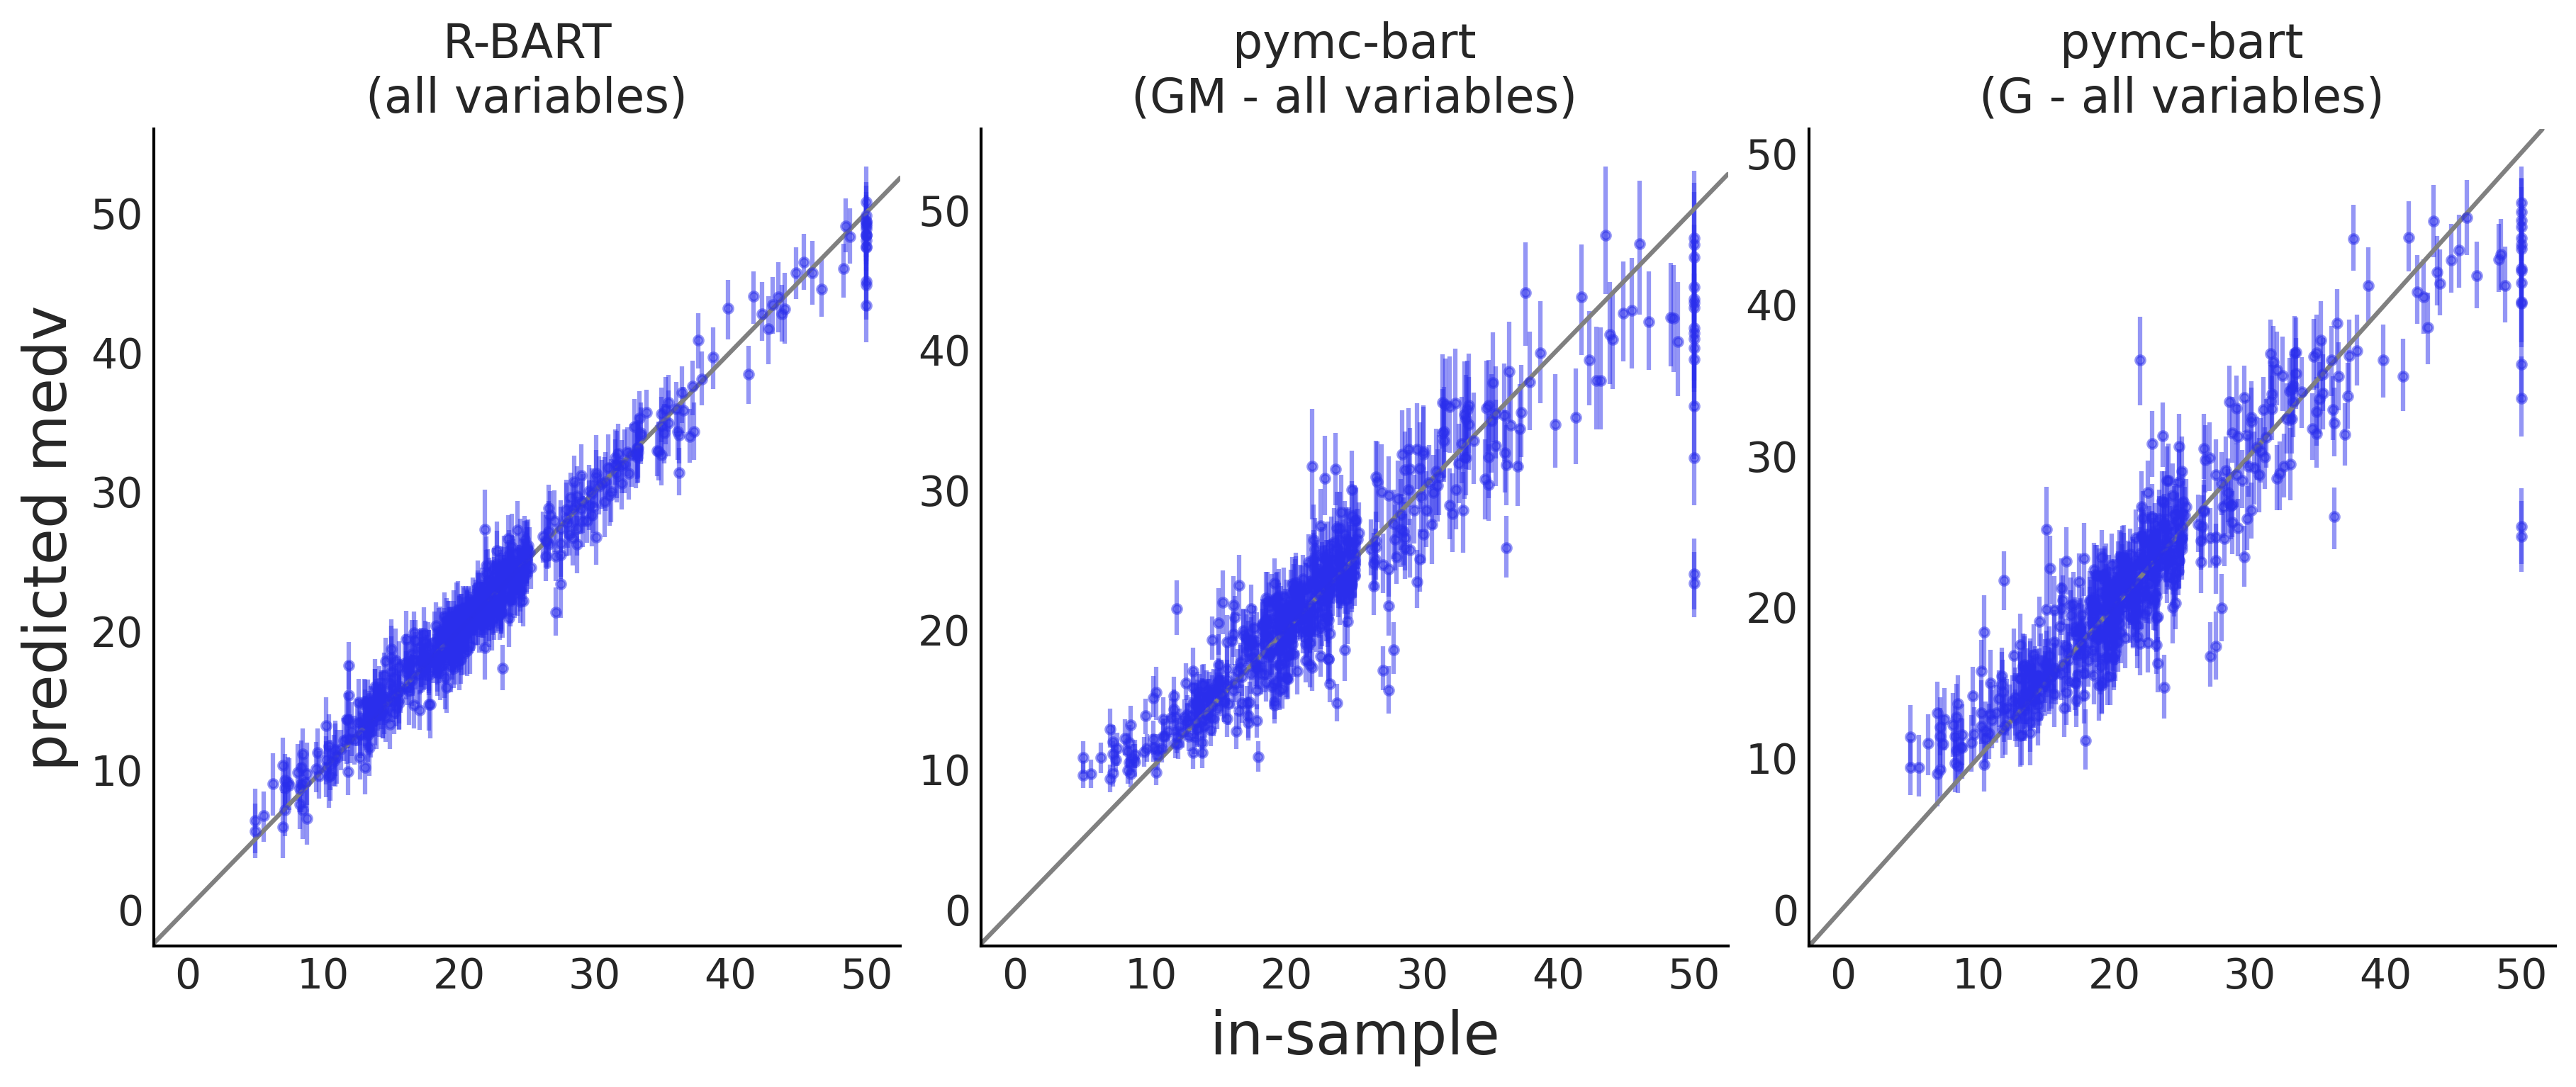

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axs = axes.ravel()

for i in range(3, len(names)):
    name = names[i]
    idata = idatas[i]
    ax = axs[i - 3]

    if name == "R-all":
        var = "y_hat"
    else:
        var = "μ"

    y_pred = idata.posterior[f"{var}"].stack(samples=["chain", "draw"])
    mean_y = y_pred.median("samples")
    mean = y_pred.mean("samples")
    hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)
    yerr = np.vstack([mean_y - hdi[:, 0], hdi[:, 1] - mean_y])
    ax.errorbar(Y, mean_y, yerr, linestyle="None", marker=".", alpha=0.5)
    ax.axline([0, 0], [1, 1], color="0.5")
    print(np.mean((Y - mean) ** 2) ** 0.5)

axs[0].set_title("R-BART\n(all variables)")
axs[1].set_title("pymc-bart\n(GM - all variables)")
axs[2].set_title("pymc-bart\n(G - all variables)")

axs[0].set_ylabel("predicted medv", size=20)
axs[1].set_xlabel("in-sample", size=20);

<xarray.DataArray ()>
array(11.91116602)
<xarray.DataArray ()>
array(11.93276083)


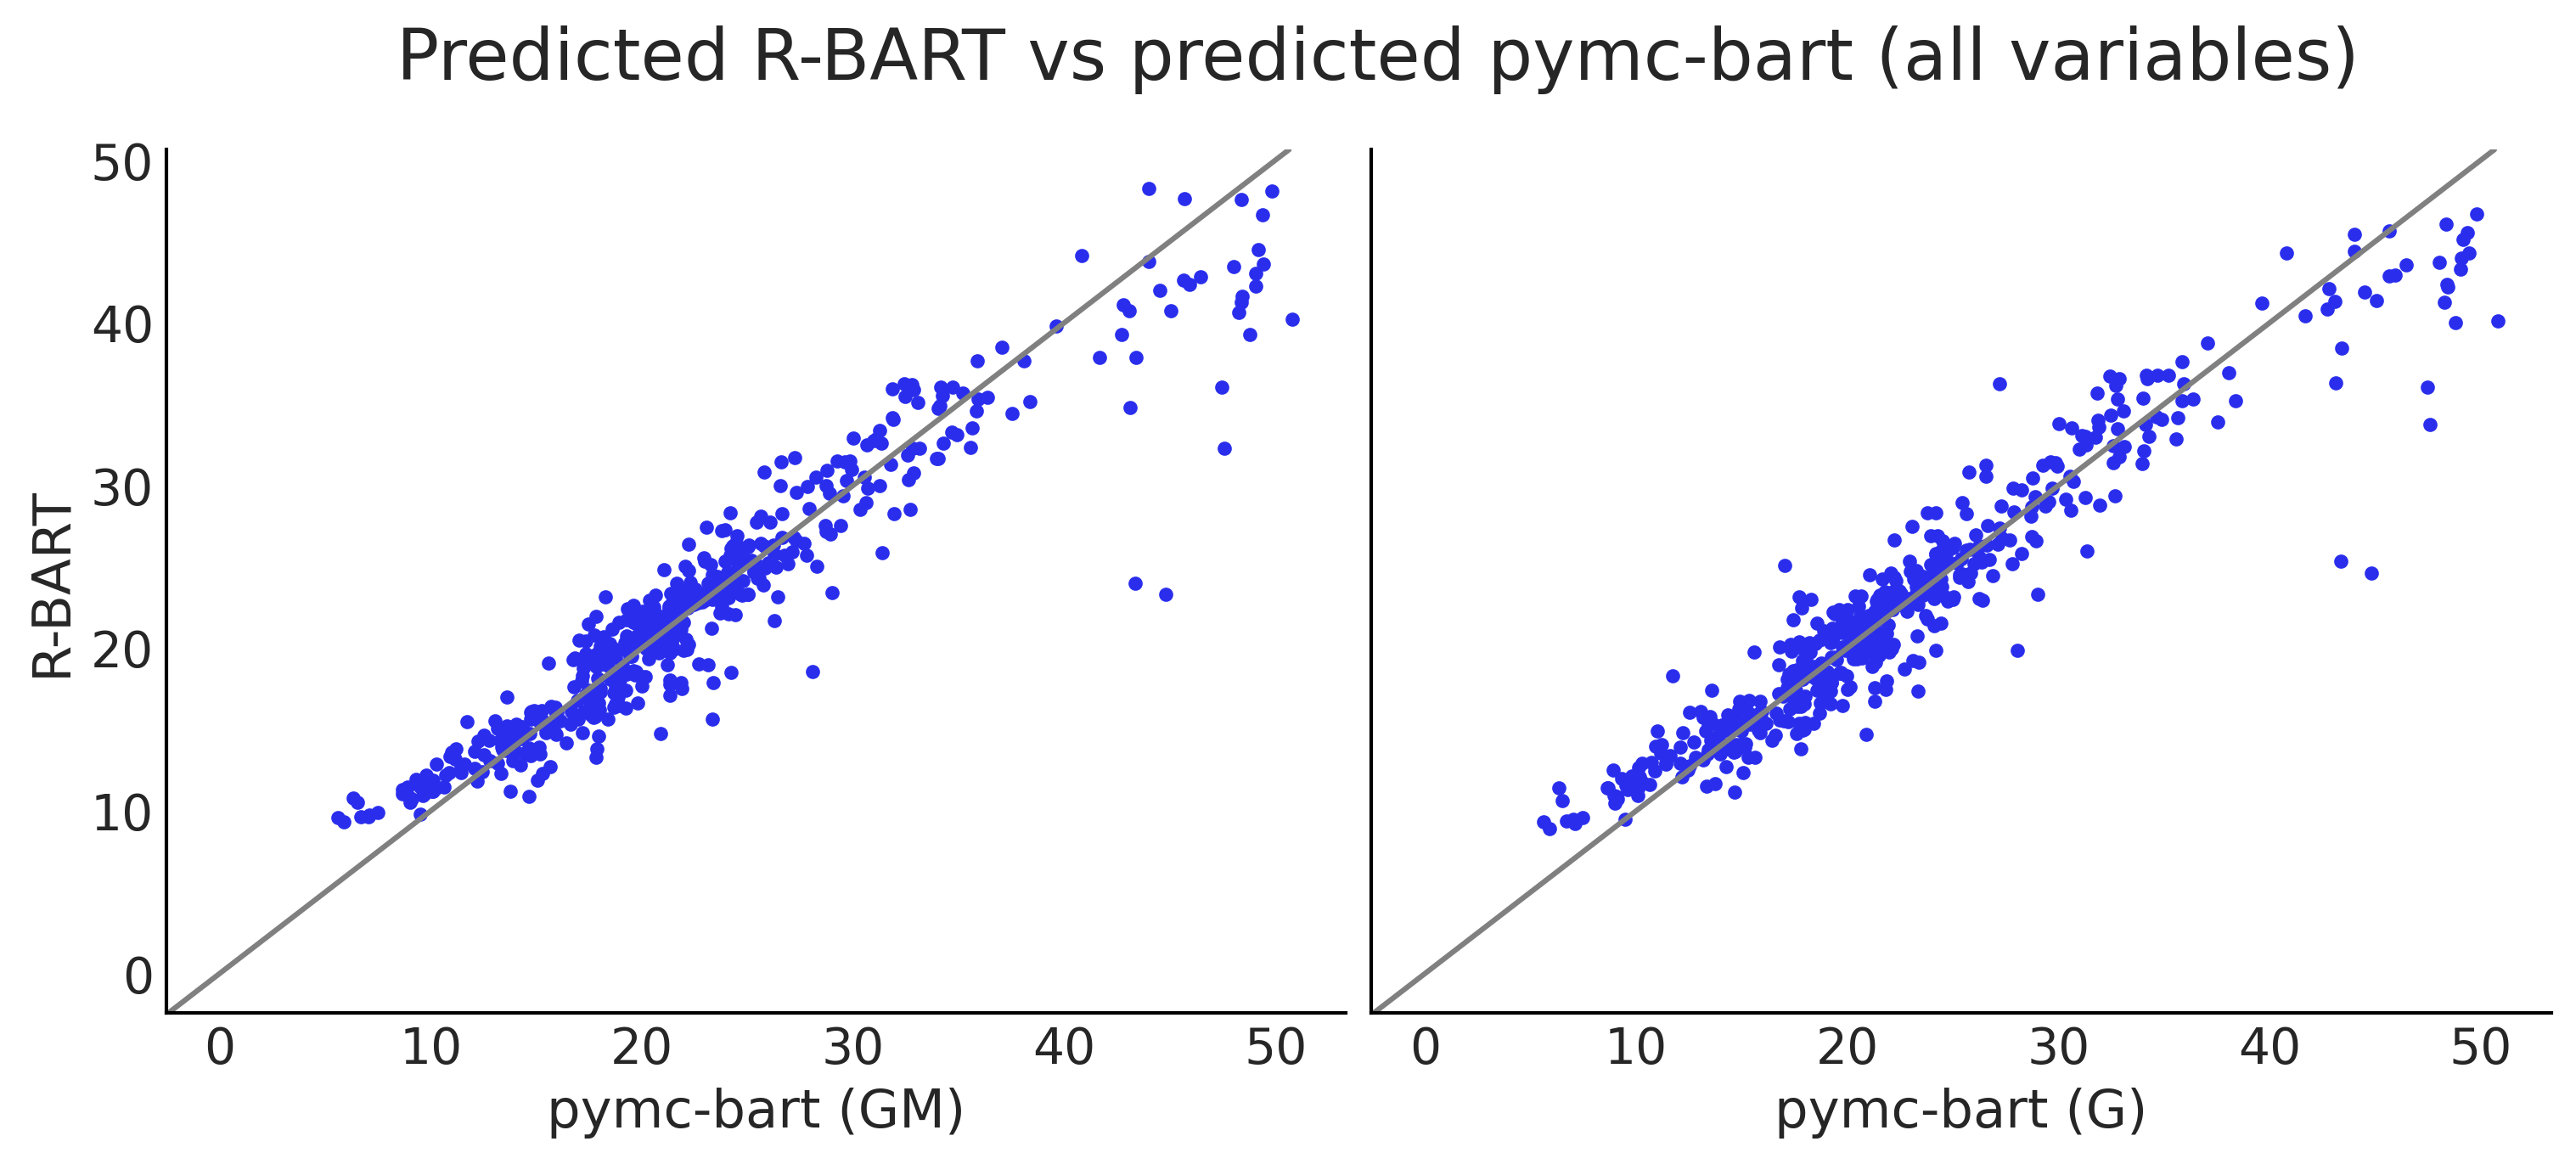

In [30]:
# Predicted pymc-bart vs R-BART
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

axs = axes.ravel()

y_r = idata_R.posterior["y_hat"].stack(samples=["chain", "draw"])
mean_r = y_r.mean("samples")

y_py = idata_pmb_GM_full.posterior["μ"].stack(samples=["chain", "draw"])
mean_py = y_py.mean("samples")

y_py2 = idata_pmb_GAUSS_full.posterior["μ"].stack(samples=["chain", "draw"])
mean_py2 = y_py2.mean("samples")

axs[0].plot(mean_r, mean_py, ".")
axs[1].plot(mean_r, mean_py2, ".")

axs[0].axline([0, 0], [1, 1], color="0.5")
axs[1].axline([0, 0], [1, 1], color="0.5")

axs[0].set_ylabel("R-BART")
axs[0].set_xlabel("pymc-bart (GM)")
axs[1].set_xlabel("pymc-bart (G)")

fig.text(
    0.15, 1.05, "Predicted R-BART vs predicted pymc-bart (all variables)", fontsize=20
)

print(np.mean((mean_r - mean_py) ** 2) ** 0.5)
print(np.mean((mean_r - mean_py2) ** 2) ** 0.5);

## RMSD and MAD  

In [31]:
cv_scores = {}
rmsd = []
mad = []

y_test = boston["medv"].values

for j in range(len(names)):
    name = names[j]
    idata = idatas[j]
    # y_hat R-BART
    if name == "R-2V" or name == "R-all":
        new_y = idata.posterior["y_hat"].stack(samples=["chain", "draw"])
    # μ pmb
    else:
        new_y = idata.posterior["μ"].stack(samples=["chain", "draw"])
    rmses = np.mean((new_y.T.squeeze() - y_test) ** 2, axis=1) ** 0.5
    rmse = np.mean(rmses)
    mads = np.median(np.abs(new_y.T.squeeze() - y_test), axis=1)
    mad = np.mean(mads)
    cv_scores[f"{name}"] = (rmse, np.std(rmses), mad, np.std(mads))

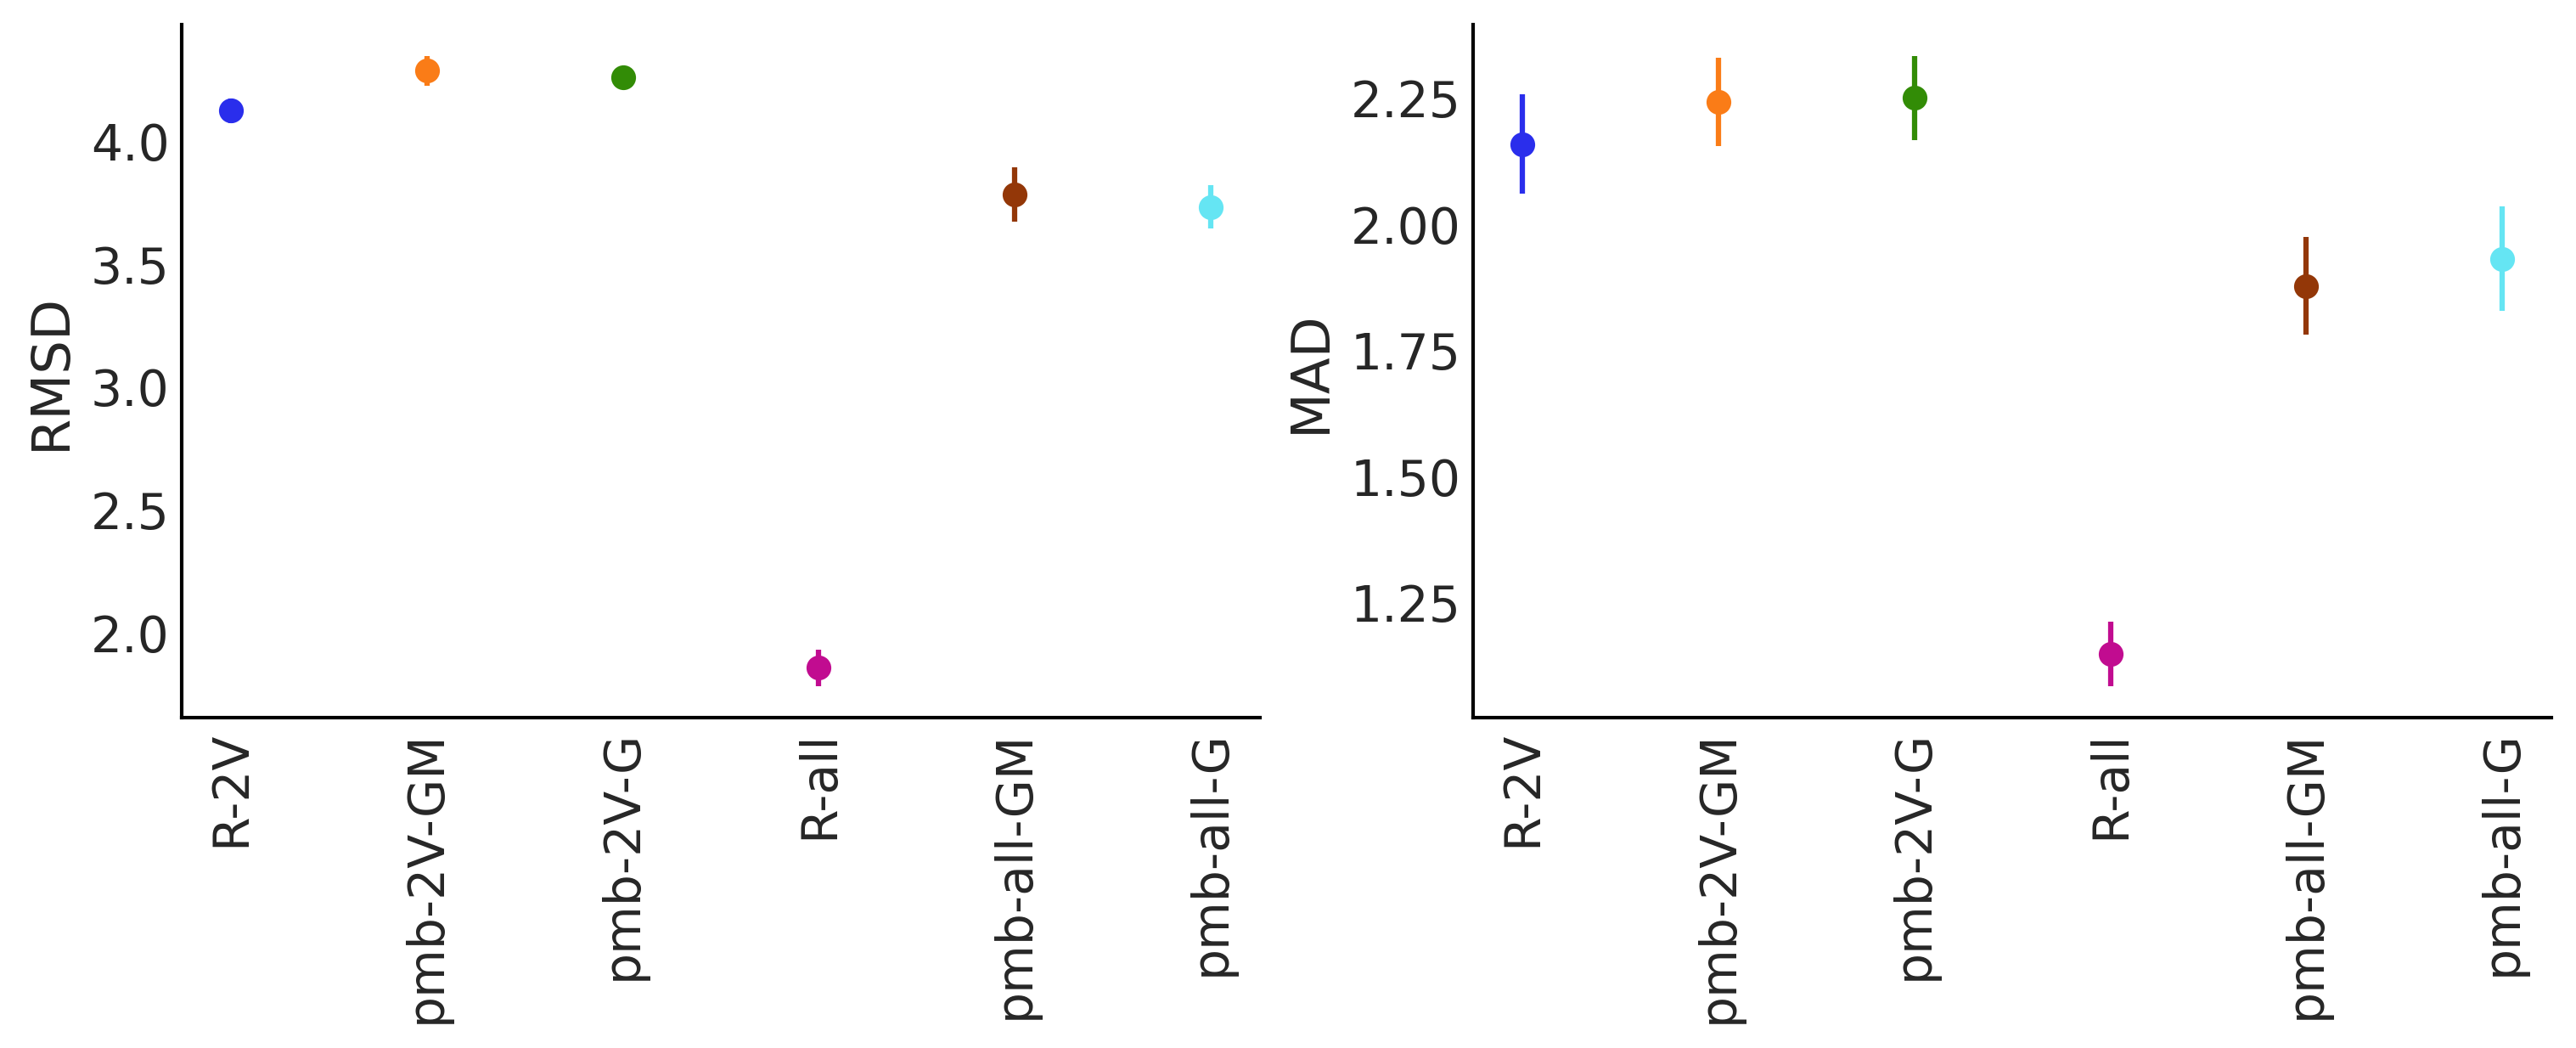

In [32]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, (k, v) in enumerate(cv_scores.items()):
    axes[0].errorbar(i, v[0], v[1], fmt="o")
    axes[1].errorbar(i, v[2], v[3], fmt="o")

axes[0].set_ylabel("RMSD")
axes[1].set_ylabel("MAD")
for ax in axes:
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=90)